In [2]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import tensorflow as tf
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt


2025-01-05 18:00:26.677672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Corpus:

In [3]:
with open('/Users/aneebaaslam/Desktop/merged_text.txt', 'r') as file:
    corpus = file.readlines()

### Tokenization and lowecase:

In [7]:
tokenized_corpus = [sentence.split() for sentence in corpus]
tokenized_corpus = [[word.lower() for word in sentence] for sentence in tokenized_corpus]

### Loading the embedding file:

In [10]:
def load_glove_embeddings(embedding_file):
    embeddings_index = {}
    with open(embedding_file, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector
    return embeddings_index


embedding_file = '/Users/aneebaaslam/Desktop/glove.6B.50d.txt'  
embeddings_index = load_glove_embeddings(embedding_file)

### Initializing Tokenizer:

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)  # Creating sequences
sequences = tokenizer.texts_to_sequences(corpus)

### Padding Sequences and Vocab Size:

In [16]:
max_sequence_length = max(len(seq) for seq in sequences)  # Longest sentence
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


vocab_size = len(tokenizer.word_index) + 1  

### Embedding Matrix:

In [19]:
all_embeddings = np.stack(list(embeddings_index.values()))
emb_mean = np.mean(all_embeddings)
emb_std = np.std(all_embeddings)


embedding_dim = 50  
embedding_matrix = np.zeros((vocab_size, embedding_dim))


for word, idx in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector  # Use the GloVe vector
    else:
        # Generate a random vector where the mean and std are aligned with GloVe's distribution
        embedding_matrix[idx] = np.random.normal(loc=emb_mean, scale=emb_std, size=(embedding_dim,))


### Splitting corpus into training and test data:

In [22]:
x = padded_sequences[:, :-1]
y = padded_sequences[:, 1:]

# Splitting the data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)


### Building Transformater Architecture:

In [25]:
# Learning rate schedule
initial_learning_rate = 0.005
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=20000,
    decay_rate=0.85,
    staircase=True
)

# Transformer model parameters
d_model = 50
num_heads = 8
dff = 128
dropout_rate = 0.1
num_layers = 4
vocab_size = 2236 
max_sequence_length = 1362 

# Input layer for the sequences
input_seq = Input(shape=(max_sequence_length,))

# Embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=d_model,
    weights=[embedding_matrix],
    trainable=False
)(input_seq)

# Encoder layers
x = embedding_layer
for i in range(num_layers):
    attn_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model
    )(x, x)

    attn_output = Dropout(dropout_rate)(attn_output)
    attn_output = LayerNormalization()(x + attn_output)

    ffn_output = Dense(dff, activation='relu')(attn_output)
    ffn_output = Dense(d_model)(ffn_output)

    ffn_output = Dropout(dropout_rate)(ffn_output)
    x = LayerNormalization()(attn_output + ffn_output)

# Output layer
output = Dense(vocab_size, activation='softmax')(x)
model = Model(inputs=input_seq, outputs=output)

### Model Summary:

In [29]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1362)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1362, 50)  │    111,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1362, 50)  │     81,250 │ embedding[0][0],  │
│ (MultiHeadAttentio… │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1362, 50)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1362, 50)  │          0 │ embedding[0][0],  │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1362, 50)  │        100 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1362, 128) │      6,528 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1362, 50)  │      6,450 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 1362, 50)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1362, 50)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1362, 50)  │        100 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1362, 50)  │     81,250 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1362, 50)  │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1362, 50)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1362, 50)  │        100 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1362, 128) │      6,528 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1362, 50)  │      6,450 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 1362, 50)  │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 1362, 50)  │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 603,548 (2.30 MB)

 Trainable params: 491,748 (1.88 MB)

 Non-trainable params: 111,800 (436.72 KB)

### Model Training:

In [31]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=33, epochs=15)

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 133s 37s/step - accuracy: 0.7283 - loss: 7.3319 - val_accuracy: 0.8781 - val_loss: 6.0498
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 95s 28s/step - accuracy: 0.9342 - loss: 5.8127 - val_accuracy: 0.8781 - val_loss: 4.8972
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 103s 32s/step - accuracy: 0.9441 - loss: 4.5851 - val_accuracy: 0.8781 - val_loss: 3.6222
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 97s 29s/step - accuracy: 0.9382 - loss: 3.2679 - val_accuracy: 0.8781 - val_loss: 2.3517
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 95s 29s/step - accuracy: 0.9287 - loss: 1.9947 - val_accuracy: 0.8781 - val_loss: 1.4483
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 110s 35s/step - accuracy: 0.9358 - loss: 1.0242 - val_accuracy: 0.8781 - val_loss: 1.2023
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 102s 30s/step - accuracy: 0.9370 - loss: 0.6934 - val_accuracy: 0.8781 - val_loss: 1.2611
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 112s 34s/step - accuracy: 0.9376 - loss: 0.6642 - val_accuracy: 0.8781 - val_loss: 1.

In [39]:
# Creating Function to generate predictions for a list of sequences

def generate_predictions(model, tokenizer, sequences, max_sequence_length):
    predictions = []  # List to store predictions
    for seq in sequences:

        # Preparing the input sequence, ensuring it's the correct shape for the model
        input_seq = seq[:max_sequence_length].reshape(1, -1)  

        pred_probs = model.predict(input_seq, verbose=0)  # Predicting probabilities for the next word

        # Mapping predicted indices to words using the tokenizer's index-to-word mapping
        pred_words = [tokenizer.index_word.get(idx, '') for idx in pred_probs.argmax(axis=-1)[0]]
        predictions.append(pred_words)  # Appending the predicted words to the list
    return predictions

In [41]:
# Creating Function to generate actual words from sequences

def generate_actuals(sequences, tokenizer):
    actuals = []  # List to store actual sequences in word form
    for seq in sequences:
        # Converting sequence indices to words
        words = [tokenizer.index_word.get(idx, '') for idx in seq]
        actuals.append(words)  # Append the actual words to the list
    return actuals

In [43]:
# Generating  predicted sequences for evaluation
predicted_sequences = generate_predictions(model, tokenizer, x_val, max_sequence_length)


# Generating actual sequences from the ground truth
actual_sequences = generate_actuals(y_val, tokenizer)


In [45]:
# Computing BLEU scores for the predicted and actual sequences
smooth_fn = SmoothingFunction().method1  # Smoothing function for BLEU scores

# Computing BLEU score for each sentence pair
bleu_scores = [sentence_bleu([actual], pred, smoothing_function=smooth_fn)
               for actual, pred in zip(actual_sequences, predicted_sequences)]
# Compute corpus-level BLEU scores with different n-gram weights
bleu_1 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.25, 0.25, 0.25, 0.25))

# Printing BLEU scores
print("BLEU Scores:")
print(f"BLEU-1: {bleu_1:.4f}")
print(f"BLEU-2: {bleu_2:.4f}")
print(f"BLEU-3: {bleu_3:.4f}")
print(f"BLEU-4: {bleu_4:.4f}")







# Computing ROUGE scores using a scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
# Initialize cumulative ROUGE scores with offsets for clarity
rouge_1, rouge_2, rouge_l = 0, 0, 0



# Iterate over actual and predicted sequences
for actual, pred in zip(actual_sequences, predicted_sequences):
    # Converting sequences to strings for scoring
    actual_str = ' '.join(actual)
    pred_str = ' '.join(pred)
    # Computing ROUGE scores for the pair
    scores = scorer.score(actual_str, pred_str)
    rouge_1 += scores['rouge1'].fmeasure  # Accumulate ROUGE-1 F1 scores
    rouge_2 += scores['rouge2'].fmeasure  # Accumulate ROUGE-2 F1 scores
    rouge_l += scores['rougeL'].fmeasure  # Accumulate ROUGE-L F1 scores



# Averaging ROUGE scores over all sequences
n = len(actual_sequences)
print("\n ROUGE Scores:")
print(f"ROUGE-1 (F1): {rouge_1 / n:.4f}")
print(f"ROUGE-2 (F1): {rouge_2 / n:.4f}")
print(f"ROUGE-L (F1): {rouge_l / n:.4f}")


BLEU Scores:
BLEU-1: 0.8781
BLEU-2: 0.8781
BLEU-3: 0.8792
BLEU-4: 0.8780

 ROUGE Scores:
ROUGE-1 (F1): 0.0000
ROUGE-2 (F1): 0.0000
ROUGE-L (F1): 0.0000


#  4×  MODEL 3 CHECK POINTS

#### Checkpoint 1: After Training glove.6B.50d Model

In [56]:
model.save('GloVe_model_checkpoint.keras')

#### Checkpoint 2: After Initializing the Embedding Matrix

In [59]:
np.save('embedding_matrix_checkpoint.npy', embedding_matrix)

#### Checkpoint 3: After Each Training Epoch

In [64]:
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint_epoch_{epoch:02d}.weights.h5',
    save_weights_only=True,
    save_best_only=False
)
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=32, epochs=15, callbacks=[checkpoint_callback])

Epoch 1/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 102s 30s/step - accuracy: 0.9447 - loss: 0.5628 - val_accuracy: 0.8781 - val_loss: 1.1953
Epoch 2/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 93s 30s/step - accuracy: 0.9306 - loss: 0.6928 - val_accuracy: 0.8781 - val_loss: 1.1784
Epoch 3/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 96s 29s/step - accuracy: 0.9372 - loss: 0.6372 - val_accuracy: 0.8781 - val_loss: 1.2032
Epoch 4/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 98s 31s/step - accuracy: 0.9383 - loss: 0.6225 - val_accuracy: 0.8781 - val_loss: 1.2311
Epoch 5/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 90s 26s/step - accuracy: 0.9345 - loss: 0.6578 - val_accuracy: 0.8781 - val_loss: 1.2326
Epoch 6/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 94s 31s/step - accuracy: 0.9324 - loss: 0.6805 - val_accuracy: 0.8781 - val_loss: 1.2196
Epoch 7/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 94s 29s/step - accuracy: 0.9300 - loss: 0.6978 - val_accuracy: 0.8781 - val_loss: 1.2059
Epoch 8/15
3/3 ━━━━━━━━━━━━━━━━━━━━ 112s 37s/step - accuracy: 0.9292 - loss: 0.7014 - val_accuracy: 0.8781 - val_loss: 1.208

In [71]:
import os
from IPython.display import FileLink

epoch = 15
filename = f'model_checkpoint_epoch_{epoch:02d}.weights.h5'

if os.path.exists(filename):
    # Create a download link
    display(FileLink(filename))
else:
    print(f"Error: File '{filename}' not found.")


/Users/aneebaaslam/Desktop/model_checkpoint_epoch_15.weights.h5

#### Checkpoint 4: Best Performance Model 

In [73]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1,
    save_weights_only=True
)

# Fit the model with the checkpoint callback, using x_train and y_train
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9445 - loss: 0.5667 
Epoch 1: val_loss improved from inf to 1.22775, saving model to best_model.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 92s 28s/step - accuracy: 0.9426 - loss: 0.5836 - val_accuracy: 0.8781 - val_loss: 1.2278
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9343 - loss: 0.6558 
Epoch 2: val_loss improved from 1.22775 to 1.22103, saving model to best_model.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 85s 27s/step - accuracy: 0.9349 - loss: 0.6504 - val_accuracy: 0.8781 - val_loss: 1.2210
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.9331 - loss: 0.6671 
Epoch 3: val_loss improved from 1.22103 to 1.21656, saving model to best_model.weights.h5
3/3 ━━━━━━━━━━━━━━━━━━━━ 86s 27s/step - accuracy: 0.9340 - loss: 0.6587 - val_accuracy: 0.8781 - val_loss: 1.2166
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9411 - loss: 0.5920 
Epoch 4: val_loss did not improve from 1.21656
3/3 ━━━━━━━━━

In [77]:
display(FileLink('best_model.weights.h5'))

/Users/aneebaaslam/Desktop/best_model.weights.h5

## **Visualizing Training and Validation losses**

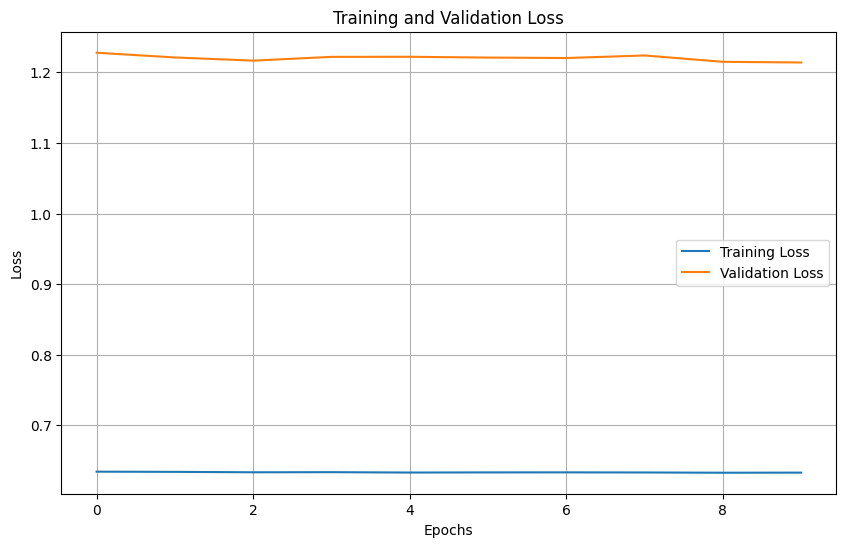

/Users/aneebaaslam/Desktop/training_validation_loss.png

Plot saved and ready for download as 'training_validation_loss.png'


In [81]:

def plot_and_download_training_history(history, filename='training_history.png'):
    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Saving the plot as an image
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

    display(FileLink(filename))
    print(f"Plot saved and ready for download as '{filename}'")

# Calling the function
plot_and_download_training_history(history, filename='training_validation_loss.png')